In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.linear_model import LassoCV, Lasso
from sklearn.feature_selection import SelectFromModel,SequentialFeatureSelector
from sklearn.metrics import roc_curve, auc, classification_report, accuracy_score, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.impute import KNNImputer
import random
import time
import shap
import ipywidgets as widgets
import pickle
from IPython.display import display
from sklearn.metrics import PrecisionRecallDisplay
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import json
shap.initjs()
random.seed(42)

In [2]:
fpr_list = []
tpr_list = []
roc_auc_list = []
random.seed(42)
def load_config(path='config.json'):
    with open(path, 'r') as file:
        return json.load(file)

def Curve(y_test,y_prob) -> None:
    # Compute the ROC curve and AUROC
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    fpr_list.append(fpr)
    tpr_list.append(tpr)
    roc_auc_list.append(roc_auc)
   
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='b', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2)  # Random classifier line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
def Matrix(y_test,y_pred) -> None:
    # Compute and plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    plt.close()

def Precision_Recall(classifier, X_test, y_test) -> None:
    display = PrecisionRecallDisplay.from_estimator(
        classifier, X_test, y_test, name="LinearSVC", plot_chance_level=True
    )
    _ = display.ax_.set_title("2-class Precision-Recall curve")

Index(['age_at_admission', 'creatinine_avg', 'neutrophil_count_avg',
       'lymphocyte_count_avg', 'neutrophil_lymphocyte_ratio', 'platelets_avg',
       'bilirubin_avg', 'systolic_bp_avg', 'diastolic_bp_avg', 'map_avg',
       'sofa_respiratory_score', 'sofa_coagulation_score', 'sofa_liver_score',
       'sofa_cardiovascular_score', 'sofa_total_score',
       'sofa_components_available', 'received_norepinephrine',
       'received_epinephrine', 'received_any_vasopressor', 'received_crrt',
       'died'],
      dtype='object')


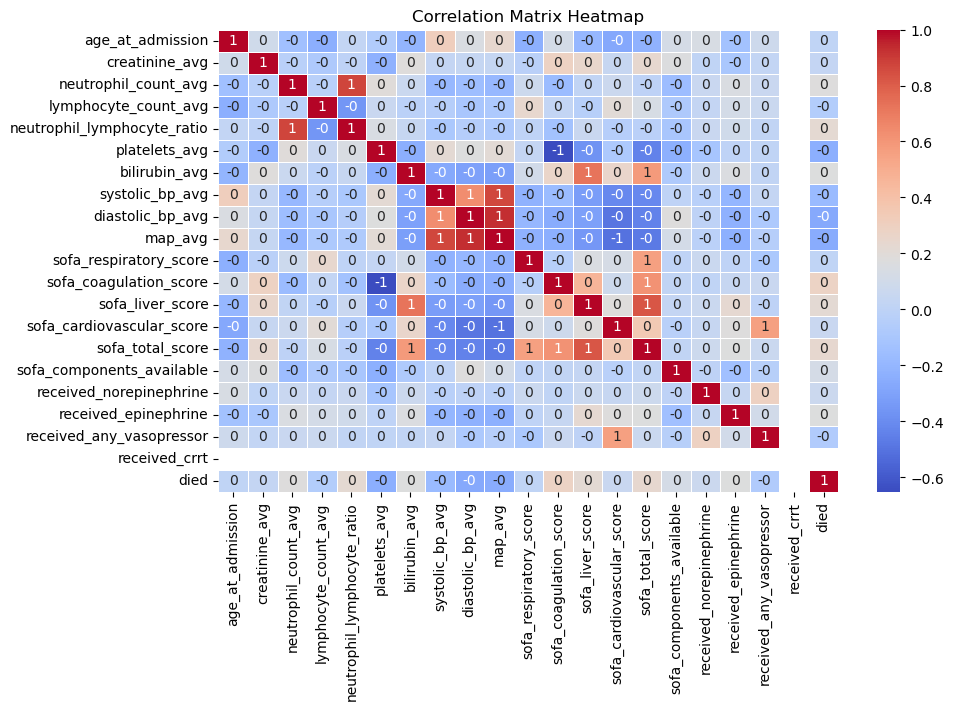

In [3]:
## import DataFrame
random.seed(42)
rediscover = pd.read_csv('rf_imputed_updated.csv')
mimic = pd.read_csv('mimic4_rf_imputed.csv')

# Select only variables that are shared between dataframes
shared_columns = rediscover.columns.intersection(mimic.columns)
shared_columns = shared_columns.drop('Unnamed: 0')
rediscover = rediscover[shared_columns]
mimic = mimic[shared_columns]
print(shared_columns)

encoder = LabelEncoder()
'''
## Applying binary map (Just in case)
binary_map = {'Yes': 1, 'No': 0}
for col in df.select_dtypes(include=['object']).columns:
    unique_vals = df[col].dropna().unique()
    if set(unique_vals).issubset(set(binary_map.keys())):
        print(f"Mapping binary column: {col}")
        df[col] = df[col].map(binary_map)
        '''

# Remove incomplete columns
'''
dropped = []
for header, series in df.items():
    if (series.isnull().sum())/len(series) > 0.1:
        dropped.append(header)
        df = df.drop(columns = header)
print("Dropped varialbes: ",dropped) 
'''

# Apply label encoding to each column of the DataFrame
#df = df.applymap(lambda x: encoder.fit_transform([x])[0] if isinstance(x, str) else x)
correlation_matrix = rediscover.corr()
plt.figure(figsize=(10, 6)) # Adjust figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm',fmt=".0f", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.savefig("heatmap.png")
plt.show()


## X and y
X = rediscover.drop(columns = ['died'])
y = rediscover['died']

## Impute missing variables
#imputer = KNNImputer(n_neighbors = 5, weights = 'uniform')
#X_imputed = imputer.fit_transform(X)
#X = pd.DataFrame(X_imputed, columns = X.columns)

## Train/Test Split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)


Selected Features: ['neutrophil_lymphocyte_ratio', 'platelets_avg', 'diastolic_bp_avg']


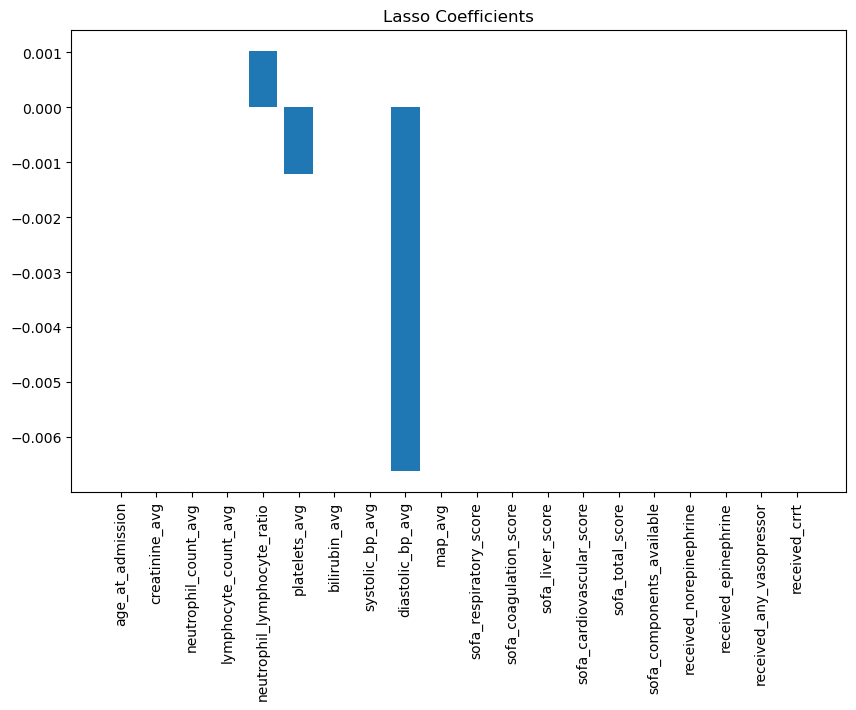

     neutrophil_lymphocyte_ratio  platelets_avg  diastolic_bp_avg
0                       8.070000     201.130000              72.8
1                      11.046300     253.800000              55.8
2                       7.888300     259.347143              69.0
3                       8.403300     280.300000              66.5
4                       7.612367     288.583333              64.8
..                           ...            ...               ...
158                     4.490000     199.000000              70.5
159                    17.000000     192.000000              80.1
160                     5.110000      73.000000              60.5
161                     7.950000     172.000000              85.5
162                    12.000000     284.000000              63.2

[163 rows x 3 columns]


In [4]:
random.seed(42)
lasso = Lasso(alpha = 0.5)
lasso.fit(X, y)

# Get the features with non-zero coefficients
selected_features = X.columns[lasso.coef_ != 0]
print("Selected Features:", list(selected_features))

# Plot coefficients
plt.figure(figsize=(10,6))
plt.bar(X.columns, lasso.coef_)
plt.xticks(rotation=90)
plt.title('Lasso Coefficients')
plt.show()

top_features = list(selected_features)
X = X[selected_features]
print(X)
## Train/Test Split
#X_train = rediscover.drop(columns = ['died'])
X_train = rediscover[top_features]
y_train = rediscover['died']
#X_test = mimic.drop(columns = ['died'])
X_test = mimic[top_features]
y_test = mimic['died']
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify = y)

Performing Nested Cross-Validation...
Nested CV completed in 2.32 seconds
Nested Cross-Validated ROC AUC Score: 0.75 ± 0.11

Training final model on full training set...
Best Hyperparameters: {'svm__gamma': 'scale', 'svm__C': 0.1}

Evaluating on Test Set...

Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.16      0.23        51
           1       0.45      0.78      0.57        45

    accuracy                           0.45        96
   macro avg       0.45      0.47      0.40        96
weighted avg       0.45      0.45      0.39        96

Accuracy Score: 0.4479166666666667
Test Set ROC AUC Score: 0.588235294117647


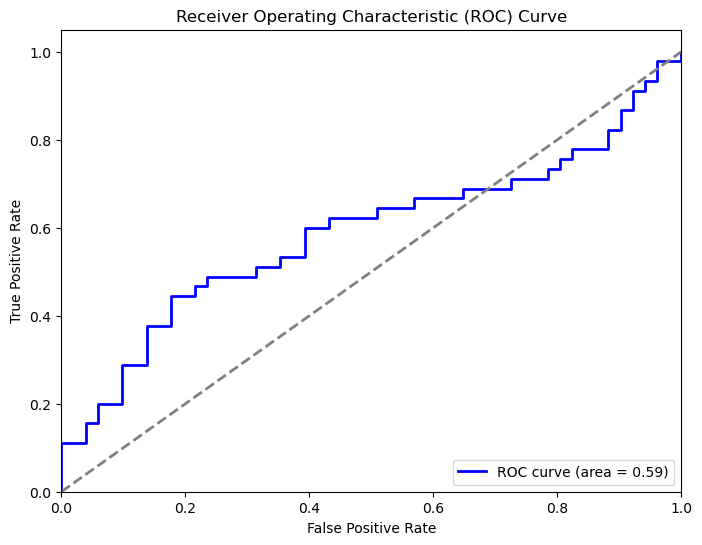

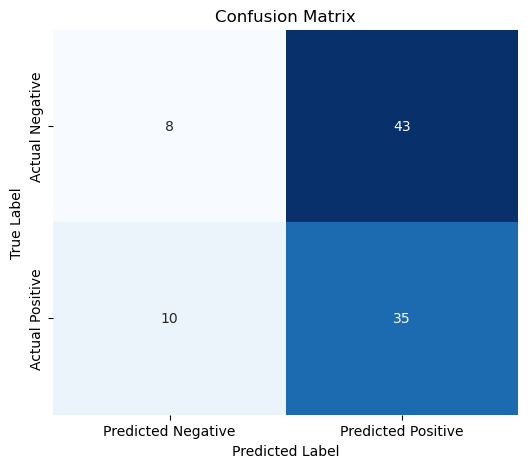

AUROC: 0.59
Setting Kernel Explainer
Setting Sample Data
Setting SHAP Values


C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


  0%|          | 0/96 [00:00<?, ?it/s]

C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler wa

Plotting SHAP summary
(96, 3)
(96, 3)


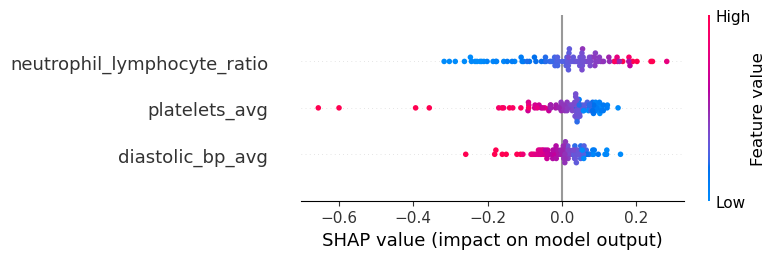

Plotting SHAP values for each feature

Generating SHAP dependence plot for feature: neutrophil_lymphocyte_ratio


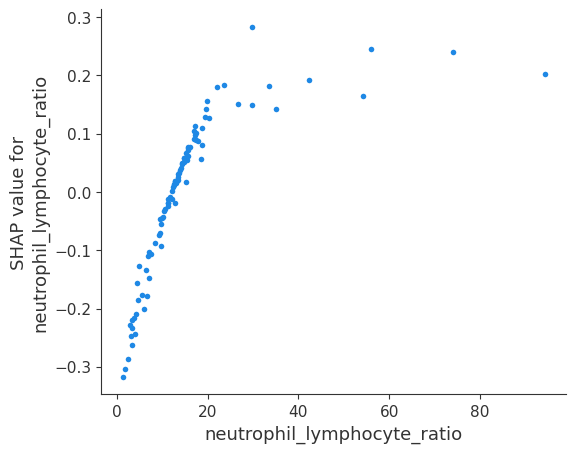


Generating SHAP dependence plot for feature: platelets_avg


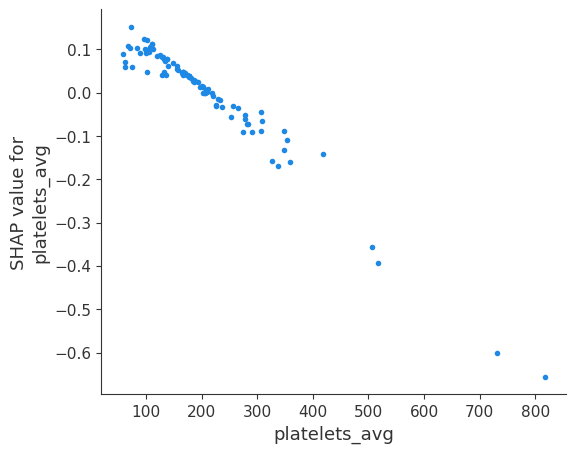


Generating SHAP dependence plot for feature: diastolic_bp_avg


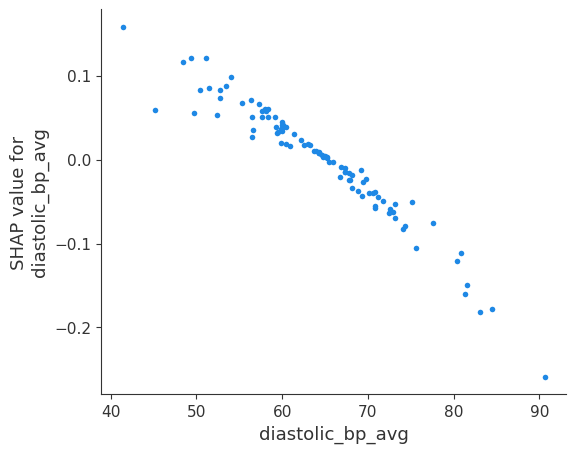

In [5]:
random.seed(42)
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Scaling
    ('svm', SVC(kernel='linear', probability = True, class_weight = 'balanced'))  # Step 3: SVM Model 
])

# Define parameter grid for hyperparameter tuning    
param_grid = {
    'svm__C': [0.1,1,10],  # SVM's C parameter
    'svm__gamma': ['scale', 'auto']  # SVM's gamma parameter
}

# Perform nested cross-validation to estimate generalization performance
print("Performing Nested Cross-Validation...")
start = time.time()

# Outer CV: Evaluating generalization performance

nested_scores = cross_val_score(
    RandomizedSearchCV(pipeline, param_distributions = param_grid, cv=5, n_jobs=-1, scoring='roc_auc', random_state=1, n_iter=6),
    X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
end = time.time()
print(f"Nested CV completed in {end - start:.2f} seconds")
print("Nested Cross-Validated ROC AUC Score: %.2f ± %.2f" % (nested_scores.mean(), nested_scores.std()))


# Best model from grid search
end = time.time()
# Now train the final model on the full training data
print("\nTraining final model on full training set...")
grid_search = RandomizedSearchCV(pipeline, param_distributions = param_grid, cv=5, n_jobs=-1, scoring='roc_auc', random_state=1, n_iter=6)
grid_search.fit(X_train, y_train)
best_pipeline = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Test set evaluation
print("\nEvaluating on Test Set...")
y_pred = best_pipeline.predict(X_test)
y_prob = best_pipeline.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Test Set ROC AUC Score:", roc_auc_score(y_test, y_prob))

# Optional: Plotting (assuming you have Curve and Matrix functions)
Curve(y_test, y_prob)
Matrix(y_test, y_pred)
Precision_Recall(best_pipeline, X_test, y_test)
plt.close()

###############################################
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr,tpr)
best_roc_auc = roc_auc
print(f"AUROC: %0.2f"%roc_auc)
pickle_model = best_pipeline
best_y_pred = y_pred
best_y_prob = y_prob
best_classifier = best_pipeline.named_steps['svm']

# Add SHAP value table
svm_model = best_pipeline.named_steps['svm']
# Select X
best_X_train = X_train
best_X_test = X_test

# Create the SHAP explainer. Since SVM is a non-tree-based model, we can use the KernelExplainer.
def pipeline_predict(X_test):
    return best_pipeline.predict_proba(X_test)

# Sample 100 instances for KernelExplainer background set
background = shap.sample(X_test, 100)

# Use full pipeline for predictions
print("Setting Kernel Explainer")
explainer = shap.KernelExplainer(pipeline_predict, background)

# Use a smaller sample for SHAP calculation (to keep it fast)
print("Setting Sample Data")
sample_data = X_test.iloc[:200]

# Compute SHAP values
print("Setting SHAP Values")
shap_values = explainer.shap_values(sample_data)

# Plot SHAP summary plot (for class 0 or 1; pick class 1 for binary classification)
print("Plotting SHAP summary")
print(shap_values[:,:,1].shape)
print(sample_data.shape)
shap.summary_plot(shap_values[:,:,1], sample_data)
plt.close()

# Optional: Dependence plots
print("Plotting SHAP values for each feature")
#for feature in top_features:
for feature in X.columns.tolist():
    print(f"\nGenerating SHAP dependence plot for feature: {feature}")
    shap.dependence_plot(
        feature,
        shap_values[:,:,1],
        sample_data,
        interaction_index=None,
        show=True
    )

Performing Nested Cross-Validation...
Nested CV completed in 8.16 seconds
Nested Cross-Validated ROC AUC Score: 0.78 ± 0.12

Training final model on full training set...
Best Hyperparameters: {'rf__warm_start': False, 'rf__n_estimators': 100, 'rf__min_samples_split': 20, 'rf__min_samples_leaf': 4, 'rf__max_depth': 40, 'rf__criterion': 'gini', 'rf__bootstrap': True}

Evaluating on Test Set...

Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.10      0.17        51
           1       0.48      0.93      0.63        45

    accuracy                           0.49        96
   macro avg       0.55      0.52      0.40        96
weighted avg       0.56      0.49      0.39        96

Accuracy Score: 0.4895833333333333
Test Set ROC AUC Score: 0.5651416122004358


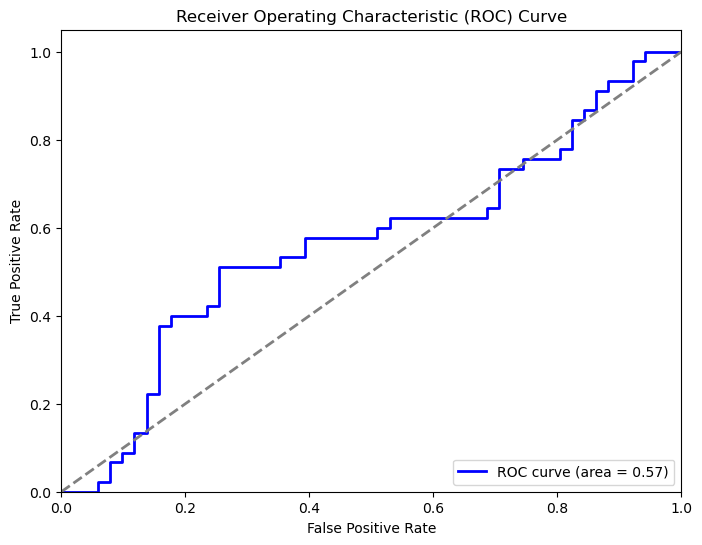

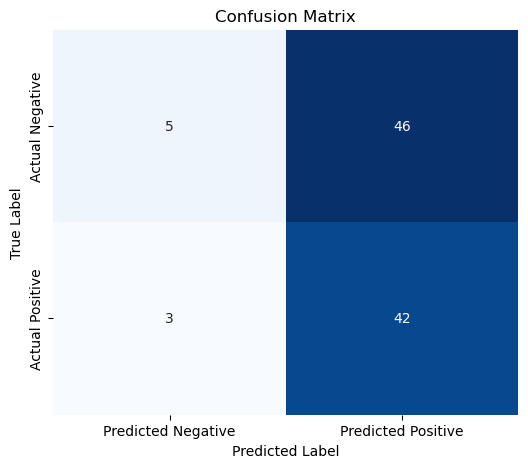

AUROC: 0.57
Setting Tree Explainer
Setting Sample Data
Setting SHAP Values
Plotting SHAP summary
(96, 3)
(96, 3)


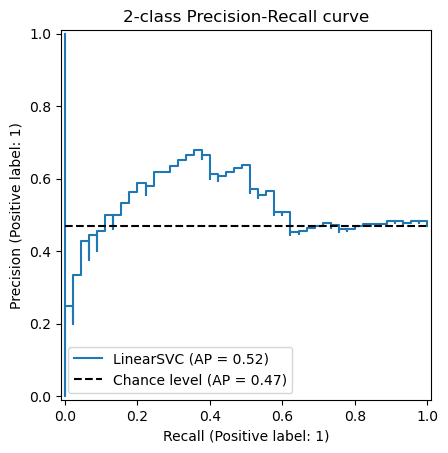

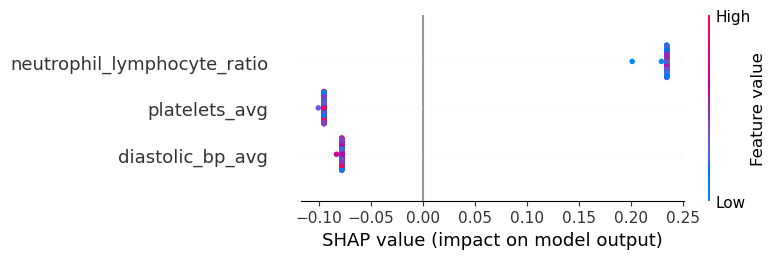

Plotting SHAP values for each feature

Generating SHAP dependence plot for feature: neutrophil_lymphocyte_ratio


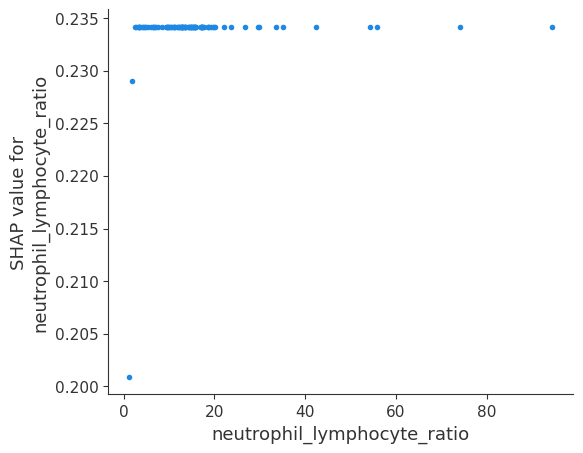


Generating SHAP dependence plot for feature: platelets_avg


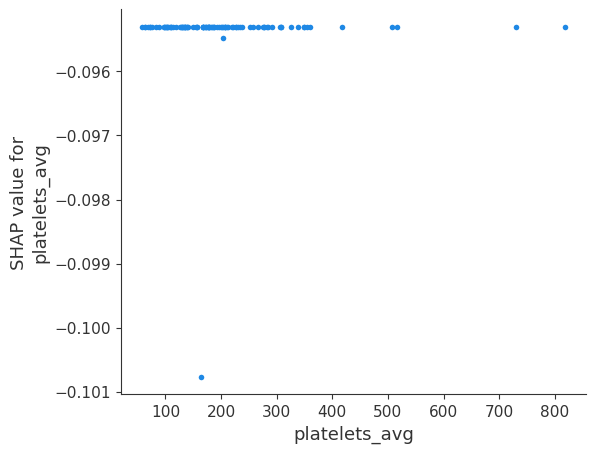


Generating SHAP dependence plot for feature: diastolic_bp_avg


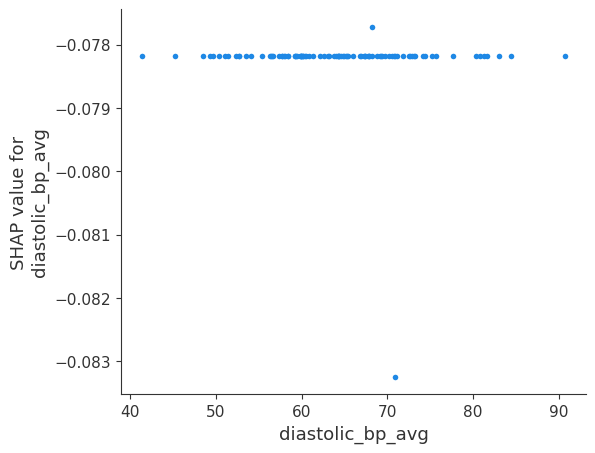

In [6]:
random.seed(42)
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Scaling
    ('rf', RandomForestClassifier(class_weight = 'balanced'))  # Step 3: RandomForest Model 
])
# Define parameter grid for hyperparameter tuning    
param_grid = {
    'rf__n_estimators': [10, 50, 100, 200, 300, 500],  # RandomForest hyperparameters
    'rf__max_depth': [None, 10, 20, 30, 40, 50],
    'rf__min_samples_split': [2, 5, 10, 20],
    'rf__min_samples_leaf': [1, 2, 4, 10],
    'rf__bootstrap': [True, False],
    'rf__criterion': ['gini', 'entropy'],
    'rf__warm_start': [True, False],
}

# Perform nested cross-validation to estimate generalization performance
print("Performing Nested Cross-Validation...")
start = time.time()

# Outer CV: Evaluating generalization performance

nested_scores = cross_val_score(
    RandomizedSearchCV(pipeline, param_distributions = param_grid, cv=5, n_jobs=-1, scoring='roc_auc', random_state=1, n_iter=10),
    X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1
)

end = time.time()
print(f"Nested CV completed in {end - start:.2f} seconds")
print("Nested Cross-Validated ROC AUC Score: %.2f ± %.2f" % (nested_scores.mean(), nested_scores.std()))

# Best model from grid search
end = time.time()
# Now train the final model on the full training data
print("\nTraining final model on full training set...")
grid_search = RandomizedSearchCV(pipeline, param_distributions = param_grid, cv=5, n_jobs=-1, scoring='roc_auc', random_state=1, n_iter=10)
grid_search.fit(X_train, y_train)

best_pipeline = grid_search.best_estimator_

print("Best Hyperparameters:", grid_search.best_params_)

# Test set evaluation
print("\nEvaluating on Test Set...")
y_pred = best_pipeline.predict(X_test)
y_prob = best_pipeline.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Test Set ROC AUC Score:", roc_auc_score(y_test, y_prob))

# Optional: Plotting (assuming you have Curve and Matrix functions)
Curve(y_test, y_prob)
Matrix(y_test, y_pred)

###############################################
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr,tpr)
print(f"AUROC: %0.2f"%roc_auc)

# Add shap value table
rf_model = best_pipeline.named_steps['rf']

Precision_Recall(best_pipeline, X_test, y_test)

if roc_auc > best_roc_auc:
    best_roc_auc = auc(fpr, tpr)
    pickle_model = best_pipeline
    best_y_pred = y_pred
    best_y_prob = y_prob
    best_classifier = best_pipeline.named_steps['rf']
    best_X_train = X_train
    best_X_test = X_test

# Sample 100 instances for KernelExplainer background set
background = shap.sample(X_test, 100)

# Use full pipeline for predictions
print("Setting Tree Explainer")
explainer = shap.TreeExplainer(best_pipeline.named_steps['rf'])

# Use a smaller sample for SHAP calculation (to keep it fast)
print("Setting Sample Data")
sample_data = X_test.iloc[:200]

# Compute SHAP values
print("Setting SHAP Values")
shap_values = explainer.shap_values(sample_data)

# Plot SHAP summary plot (for class 0 or 1; pick class 1 for binary classification)
print("Plotting SHAP summary")
print(shap_values[:,:,1].shape)
print(sample_data.shape)
plt.show()
shap.summary_plot(shap_values[:,:,1], sample_data)
plt.show()

# Optional: Dependence plots
print("Plotting SHAP values for each feature")
for feature in X.columns.tolist():
    print(f"\nGenerating SHAP dependence plot for feature: {feature}")
    shap.dependence_plot(
        feature,
        shap_values[:,:,1],
        sample_data,
        interaction_index=None,
        show=True
    )

Performing Nested Cross-Validation...
Nested CV completed in 18.87 seconds
Nested Cross-Validated ROC AUC Score: 0.78 ± 0.09

Training final model on full training set...
      Iter       Train Loss   Remaining Time 
         1           1.3531            0.13s
         2           1.3467            0.15s
         3           1.3415            0.13s
         4           1.3337            0.12s
         5           1.3294            0.13s
         6           1.3243            0.14s
         7           1.3165            0.14s
         8           1.3115            0.14s
         9           1.3063            0.14s
        10           1.3001            0.14s
        11           1.2954            0.14s
        12           1.2880            0.14s
        13           1.2831            0.14s
        14           1.2788            0.13s
        15           1.2725            0.13s
        16           1.2661            0.13s
        17           1.2598            0.13s
        18        

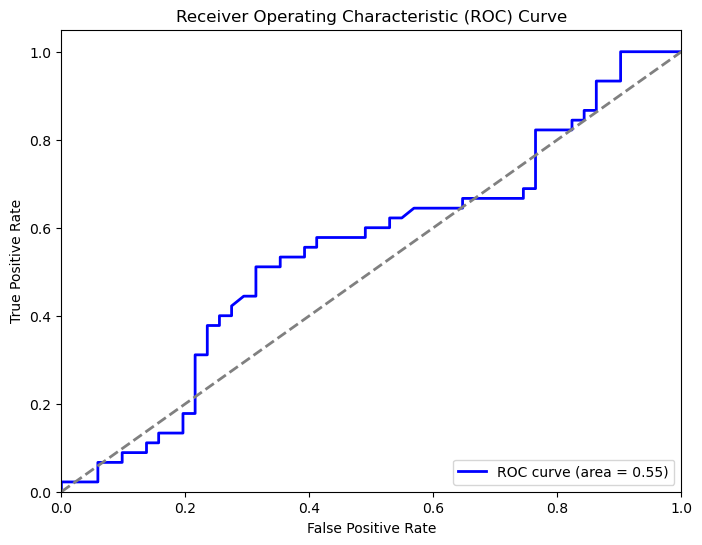

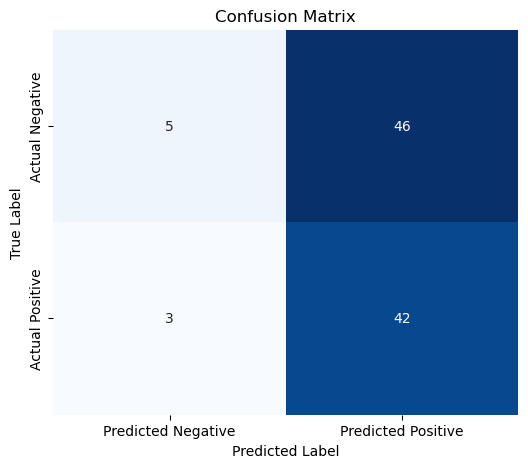

AUROC: 0.55
Setting Tree Explainer
Setting Sample Data
Setting SHAP Values
Plotting SHAP summary
(96, 3)
(96, 3)


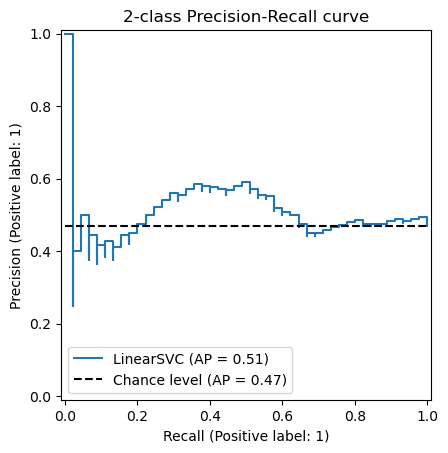

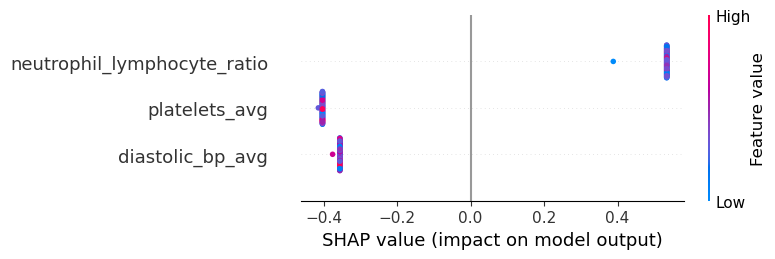

Plotting SHAP values for each feature

Generating SHAP dependence plot for feature: neutrophil_lymphocyte_ratio


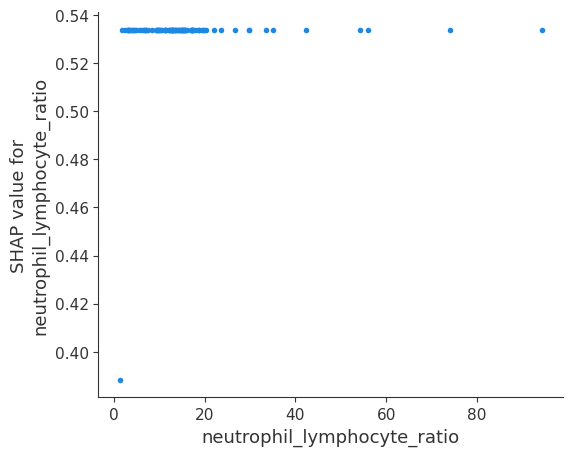


Generating SHAP dependence plot for feature: platelets_avg


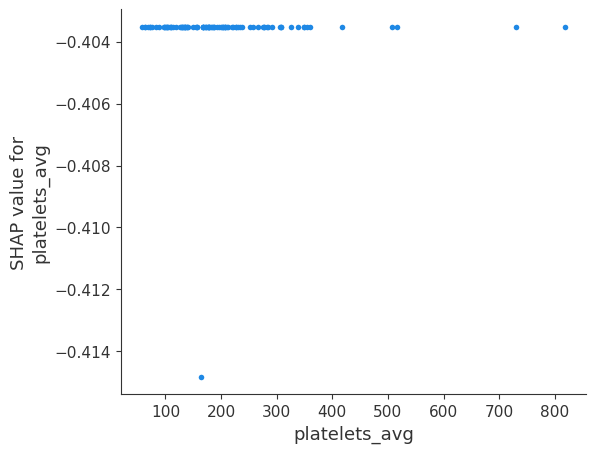


Generating SHAP dependence plot for feature: diastolic_bp_avg


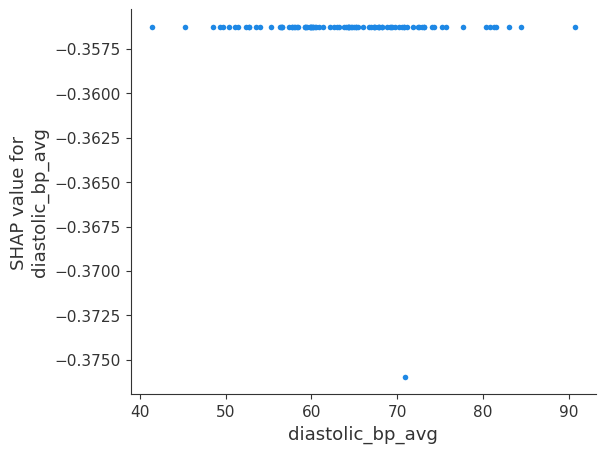

In [7]:
random.seed(42)
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Scaling
    ('xgb', GradientBoostingClassifier())  # Step 3: XGBoost Model 
])

# Define parameter grid for hyperparameter tuning    
param_grid = {
    'xgb__n_estimators': [50, 100, 200, 300, 500],  # Number of boosting stages (trees)
    'xgb__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],  # Step size shrinking to prevent overfitting
    'xgb__max_depth': [3, 4, 5, 6, 7],  # Maximum depth of the individual trees
    'xgb__min_samples_split': [2, 5, 10, 20],  # Minimum number of samples required to split an internal node
    'xgb__min_samples_leaf': [1, 2, 4, 10],  # Minimum number of samples required to be at a leaf node
    'xgb__subsample': [0.8, 0.9, 1.0],  # Fraction of samples used for fitting each base estimator (for stochastic gradient boosting)
    'xgb__max_features': ['sqrt', 'log2', None],  # The number of features to consider when splitting a node
    'xgb__criterion': ['friedman_mse', 'squared_error'],  # The loss function to optimize (Friedman MSE is the default)
    'xgb__verbose': [0, 1, 2],  # Controls the verbosity of the output during fitting
    'xgb__n_iter_no_change': [None, 10, 20],  # Number of iterations with no improvement before stopping the training
    'xgb__warm_start': [True, False],  # Whether to reuse the solution of the previous fit and add more estimators
    'xgb__max_leaf_nodes': [None, 10, 20, 50],  # Maximum number of leaf nodes in each tree
    'xgb__validation_fraction': [0.1, 0.2, 0.3],  # Proportion of training data to set aside for early stopping
}

# Perform nested cross-validation to estimate generalization performance
print("Performing Nested Cross-Validation...")
start = time.time()

nested_scores = cross_val_score(
    RandomizedSearchCV(pipeline, param_distributions = param_grid, cv=5, n_jobs=-1, scoring='roc_auc', random_state=1, n_iter=10),
    X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1
)
end = time.time()
print(f"Nested CV completed in {end - start:.2f} seconds")
print("Nested Cross-Validated ROC AUC Score: %.2f ± %.2f" % (nested_scores.mean(), nested_scores.std()))


# Best model from grid search
end = time.time()
# Now train the final model on the full training data
print("\nTraining final model on full training set...")
grid_search = RandomizedSearchCV(pipeline, param_distributions = param_grid, cv=5, n_jobs=-1, scoring='roc_auc', random_state=1, n_iter=10)
grid_search.fit(X_train, y_train)

best_pipeline = grid_search.best_estimator_

print("Best Hyperparameters:", grid_search.best_params_)

# Test set evaluation
print("\nEvaluating on Test Set...")
y_pred = best_pipeline.predict(X_test)
y_prob = best_pipeline.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Test Set ROC AUC Score:", roc_auc_score(y_test, y_prob))

Curve(y_test, y_prob)
Matrix(y_test, y_pred)

###############################################
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr,tpr)
print(f"AUROC: %0.2f"%roc_auc)

# Add shap value table
xgb_model = best_pipeline.named_steps['xgb']
Precision_Recall(best_pipeline, X_test, y_test)

if roc_auc > best_roc_auc:
    best_roc_auc = auc(fpr, tpr)
    pickle_model = best_pipeline
    best_y_pred = y_pred
    best_y_prob = y_prob
    best_classifier = best_pipeline.named_steps['xgb']
    best_X_train = X_train
    best_X_test = X_test


# Create the SHAP explainer.
# Use full pipeline for predictions
print("Setting Tree Explainer")
explainer = shap.TreeExplainer(best_pipeline.named_steps['xgb'])

# Use a smaller sample for SHAP calculation (to keep it fast)
print("Setting Sample Data")
sample_data = X_test.iloc[:200]

# Compute SHAP values
print("Setting SHAP Values")
shap_values = explainer.shap_values(sample_data)

# Plot SHAP summary plot (for class 0 or 1; pick class 1 for binary classification)
print("Plotting SHAP summary")
#print(shap_values[:,:,1].shape)
print(shap_values.shape)
print(sample_data.shape)
plt.show()
shap.summary_plot(shap_values, sample_data)
plt.show()

# Optional: Dependence plots
print("Plotting SHAP values for each feature")
for feature in X.columns.tolist():
    print(f"\nGenerating SHAP dependence plot for feature: {feature}")
    shap.dependence_plot(
        feature,
        shap_values,
        sample_data,
        interaction_index=None,
        show=True
    )

Performing Nested Cross-Validation...
Nested CV completed in 10.75 seconds
Nested Cross-Validated ROC AUC Score: 0.66 ± 0.20

Training final model on full training set...
Best Hyperparameters: {'mlp__solver': 'adam', 'mlp__max_iter': 200, 'mlp__learning_rate_init': 0.01, 'mlp__learning_rate': 'adaptive', 'mlp__hidden_layer_sizes': (100,), 'mlp__early_stopping': True, 'mlp__alpha': 0.0001, 'mlp__activation': 'tanh'}

Evaluating on Test Set...

Classification Report:
               precision    recall  f1-score   support

           0       0.42      0.10      0.16        51
           1       0.45      0.84      0.59        45

    accuracy                           0.45        96
   macro avg       0.43      0.47      0.37        96
weighted avg       0.43      0.45      0.36        96

Accuracy Score: 0.4479166666666667
Test Set ROC AUC Score: 0.5830065359477125


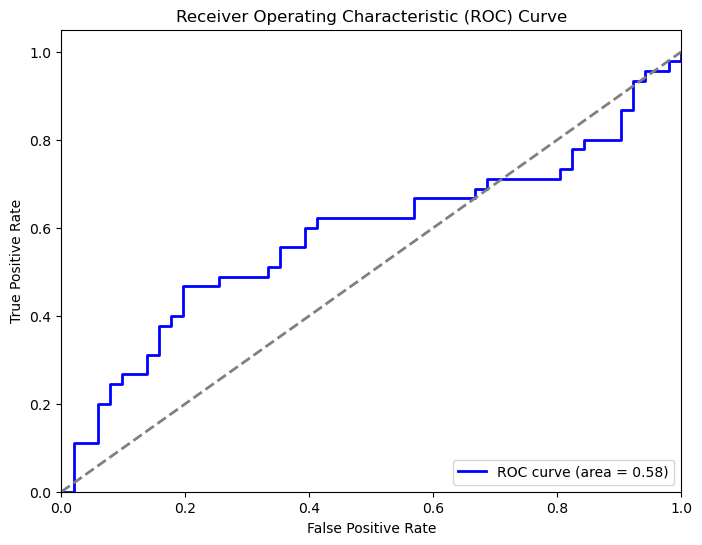

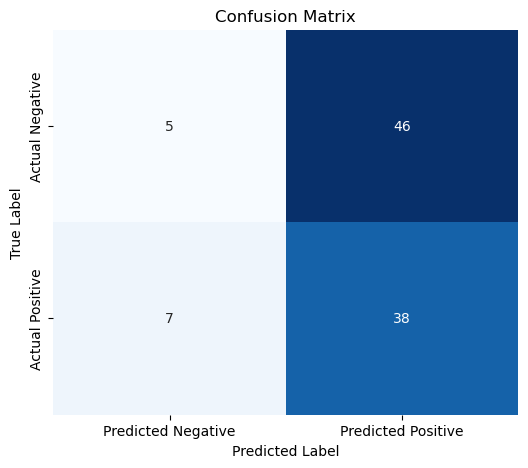

AUROC: 0.58
Setting Kernel Explainer
Setting Sample Data
Setting SHAP Values


C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


  0%|          | 0/96 [00:00<?, ?it/s]

C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\m171548\AppData\Local\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler wa

Plotting SHAP summary
(96, 3)
(96, 3)


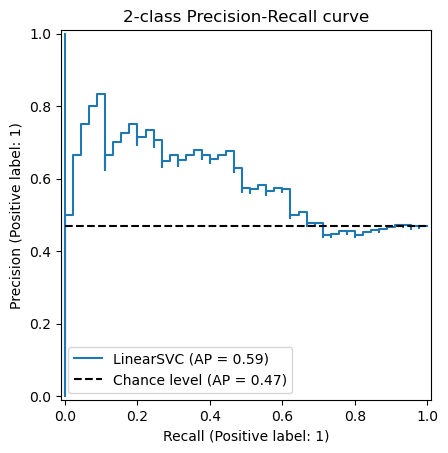

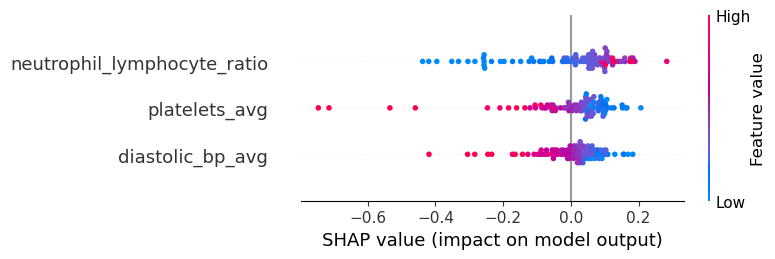

Plotting SHAP values for each feature

Generating SHAP dependence plot for feature: neutrophil_lymphocyte_ratio


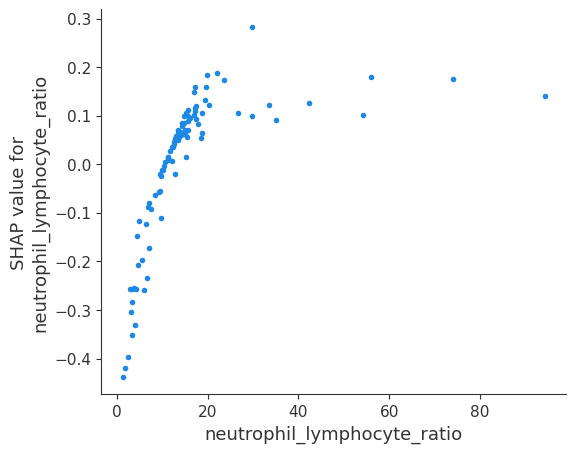


Generating SHAP dependence plot for feature: platelets_avg


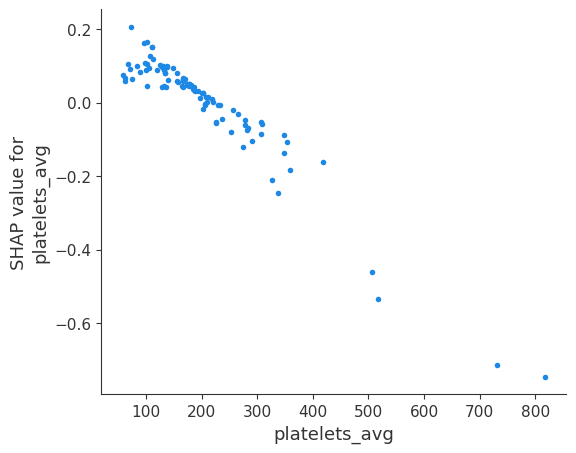


Generating SHAP dependence plot for feature: diastolic_bp_avg


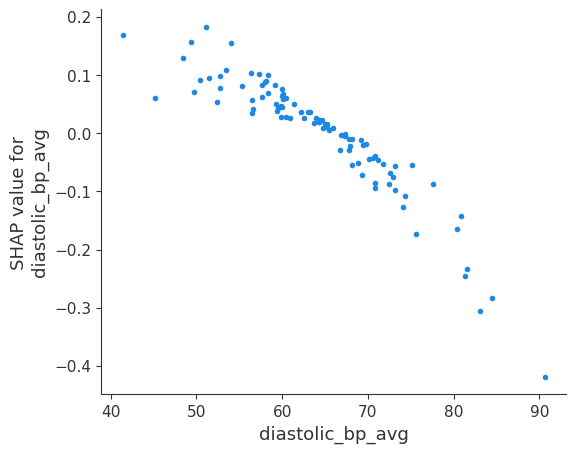

In [8]:
random.seed(42)
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Step 1: Scaling
    ('mlp', MLPClassifier())  # Step 3: MLP Classifier Model 
])
    
# Define parameter grid for hyperparameter tuning    
param_grid = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
    'mlp__activation': ['tanh', 'relu', 'logistic'],
    'mlp__solver': ['adam', 'sgd', 'lbfgs'],
    'mlp__alpha': [0.0001, 0.001, 0.01, 0.1],  # L2 penalty (regularization term)
    'mlp__learning_rate': ['constant', 'invscaling', 'adaptive'],
    'mlp__learning_rate_init': [0.001, 0.01, 0.1],
    'mlp__max_iter': [200, 300, 500],
    'mlp__early_stopping': [True, False],
}

# Perform nested cross-validation to estimate generalization performance
print("Performing Nested Cross-Validation...")
start = time.time()

# Outer CV: Evaluating generalization performance
nested_scores = cross_val_score(
    RandomizedSearchCV(pipeline, param_distributions = param_grid, cv=5, n_jobs=-1, scoring='roc_auc', random_state=1, n_iter=10),
    X_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1
)

end = time.time()
print(f"Nested CV completed in {end - start:.2f} seconds")
print("Nested Cross-Validated ROC AUC Score: %.2f ± %.2f" % (nested_scores.mean(), nested_scores.std()))


# Best model from grid search
end = time.time()
# Now train the final model on the full training data
print("\nTraining final model on full training set...")
grid_search = RandomizedSearchCV(pipeline, param_distributions = param_grid, cv=5, n_jobs=-1, scoring='roc_auc', random_state=1, n_iter=10)
grid_search.fit(X_train, y_train)

best_pipeline = grid_search.best_estimator_

print("Best Hyperparameters:", grid_search.best_params_)

# Test set evaluation
print("\nEvaluating on Test Set...")
y_pred = best_pipeline.predict(X_test)
y_prob = best_pipeline.predict_proba(X_test)[:, 1]

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("Test Set ROC AUC Score:", roc_auc_score(y_test, y_prob))

# Optional: Plotting (assuming you have Curve and Matrix functions)
Curve(y_test, y_prob)
Matrix(y_test, y_pred)

###############################################
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr,tpr)
print(f"AUROC: %0.2f"%roc_auc)

# Add shap value table
mlp_model = best_pipeline.named_steps['mlp']
# Select X
Precision_Recall(best_pipeline, X_test, y_test)

if roc_auc > best_roc_auc:
    best_roc_auc = auc(fpr, tpr)
    pickle_model = best_pipeline
    best_y_pred = y_pred
    best_y_prob = y_prob
    best_classifier = best_pipeline.named_steps['mlp']
    best_X_train = X_train
    best_X_test = X_test

# Sample 100 instances for KernelExplainer background set
background = shap.sample(X_test, 100)

# Use full pipeline for predictions
print("Setting Kernel Explainer")
explainer = shap.KernelExplainer(pipeline_predict, background)

# Use a smaller sample for SHAP calculation (to keep it fast)
print("Setting Sample Data")
sample_data = X_test.iloc[:200]

# Compute SHAP values
print("Setting SHAP Values")
shap_values = explainer.shap_values(sample_data)

# Plot SHAP summary plot (for class 0 or 1; pick class 1 for binary classification)
print("Plotting SHAP summary")
print(shap_values[:,:,1].shape)
print(sample_data.shape)
plt.show()
shap.summary_plot(shap_values[:,:,1], sample_data)
plt.show()

# Optional: Dependence plots
print("Plotting SHAP values for each feature")
for feature in X.columns.tolist():
    print(f"\nGenerating SHAP dependence plot for feature: {feature}")
    shap.dependence_plot(
        feature,
        shap_values[:,:,1],
        sample_data,
        interaction_index=None,
        show=True
    )

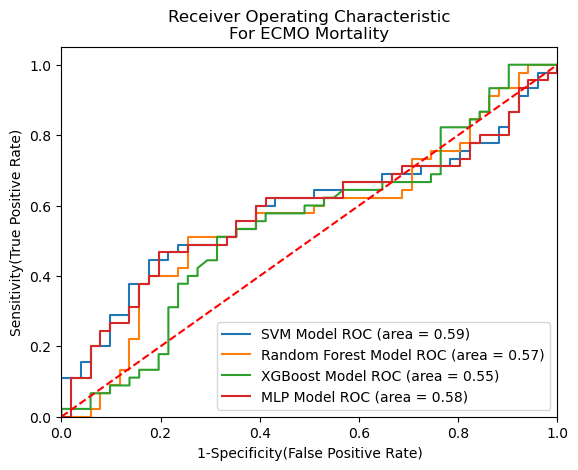

In [9]:
# Create AUC ROC Curve overlay
plt.plot(fpr_list[0], tpr_list[0], label ='%s ROC (area = %0.2f)' % ("SVM Model", roc_auc_list[0]))
plt.plot(fpr_list[1], tpr_list[1], label ='%s ROC (area = %0.2f)' % ("Random Forest Model", roc_auc_list[1]))
plt.plot(fpr_list[2], tpr_list[2], label ='%s ROC (area = %0.2f)' % ("XGBoost Model", roc_auc_list[2]))
plt.plot(fpr_list[3], tpr_list[3], label ='%s ROC (area = %0.2f)' % ("MLP Model", roc_auc_list[3]))

# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic\nFor ECMO Mortality')
plt.legend(loc="lower right")
plt.savefig('ROCAUC.png')
plt.show()   # Display